In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sbs
import os
import pickle

from ml.dataset.mnist import load as load_mnist, init as init_mnist, download_mnist

MNIST_PATH = "../data/mnist"

if not os.path.exists(MNIST_PATH):
    os.mkdir(MNIST_PATH)
    init_mnist(MNIST_PATH)

x_train, y_train, x_test, y_test = load_mnist(MNIST_PATH)
x_train = np.array(((x_train / 256) - 0.5) / 0.5)  # Normalize
y_train = np.array([[int(x == y) for x in range(10)] for y in y_train])
x_test = np.array(((x_test / 256) - 0.5) / 0.5)  # Normalize
y_test = np.array([[int(x == y) for x in range(10)] for y in y_test])

In [3]:
from ml.nn.base import NeuralNetwork
from ml.nn.loss import BinaryCrossEntropyLoss, MSELoss
from ml.nn.layer import Softmax, LeakyReLU, Dropout, Sigmoid, Linear, Conv2d, Reshape, Flatten
from ml.nn.optim import Adam, SGD
import json

nn = NeuralNetwork([
    Reshape((1, 28, 28)),
    Conv2d(1, 3, kernel=3, padding=1),
    Conv2d(3, 1, kernel=3, padding=1),
    Flatten(),
    Linear(784, 512),
    LeakyReLU(0.2),
    Linear(512, 10),
    Softmax()
], BinaryCrossEntropyLoss(), Adam(1e-4))

In [4]:
from typing import Tuple


def train_nn(batch_size: int, epoch_size: int, save_path: str = "../model.pkl") -> Tuple[np.ndarray, np.ndarray]:
    data_size = len(x_train)
    data_pos = np.arange(len(x_train))

    loss_data = np.zeros(len(range(0, data_size, batch_size)) * epoch_size)
    loss_data_on = 0

    loss_epoch = np.zeros(epoch_size)

    nn.train()

    for epoch in range(1, epoch_size + 1):
        np.random.shuffle(data_pos)
        loss_total = 0.
        for i in range(0, data_size, batch_size):
            p = data_pos[i:min(i + batch_size, data_size)]
            nn.zero_grad()
            result = nn(x_train[p])
            loss = nn.loss(y_train[p])
            nn.backward()
            nn.step()
            loss_total += loss.item()
            print(f"\r{epoch}; {i}/{data_size}; {round(loss.item(), 5)} {' ' * 30}", end="")

            loss_data[loss_data_on] = loss
            loss_data_on += 1

        loss_total /= len(range(0, data_size, batch_size))
        print(f"\r{epoch}; Loss total: {round(loss_total, 5)}. {' ' * 30}")

        loss_epoch[epoch - 1] = loss_total

    if save_path is not None:
        with open(save_path, "wb+") as f:
            pickle.dump(nn.state_dict(), f)

    return loss_data, loss_epoch


loss_on_iter, loss_on_epoch = train_nn(256, 10)

1; Loss total: 0.24743.                               
2; Loss total: 0.18356.                               
3; Loss total: 0.01486.                               
4; Loss total: 0.01048.                               
5; Loss total: 0.00797.                               
6; Loss total: 0.00677.                               
7; Loss total: 0.00564.                               
8; Loss total: 0.00492.                               
9; Loss total: 0.00444.                               
10; Loss total: 0.00392.                               


<AxesSubplot: >

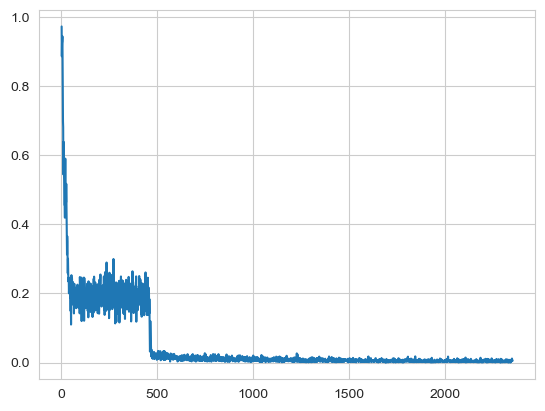

In [5]:
sbs.lineplot(y=loss_on_iter, x=np.arange(loss_on_iter.shape[0]) + 1)

<AxesSubplot: >

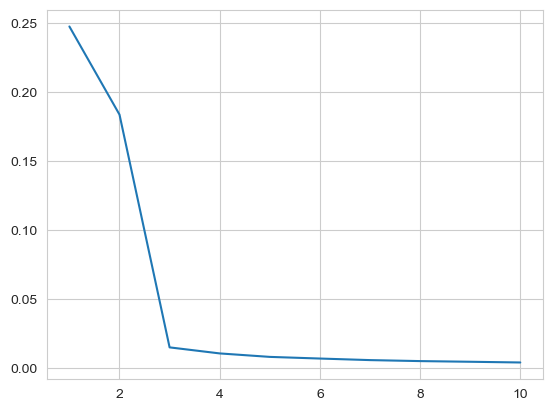

In [6]:
sbs.lineplot(y=loss_on_epoch, x=np.arange(len(loss_on_epoch)) + 1)

In [8]:
from typing import Tuple


def test_nn(batch_size: int = 256, model_path: str = "../model.pkl",
            data_set: Tuple[np.ndarray, np.ndarray] = (x_test, y_test)) -> Tuple[int, int, int, float]:
    with open(model_path, "rb+") as f:
        nn.load_state_dict(pickle.load(f))

    data, lbl = data_set

    total = len(data)
    data_pos = np.arange(total)

    correct = 0
    loss = 0.
    epoch_cnt = len(range(0, total, batch_size))

    cnt = 0

    nn.eval()

    for i in range(0, total, batch_size):
        p = data_pos[i: min(i + batch_size, total)]
        x = data[p]
        y = lbl[p]

        nn.zero_grad()
        result = nn(x)

        loss_round = nn.loss(y)

        loss += loss_round
        correct_round = np.sum(np.argmax(result, axis=1) == np.argmax(y, axis=1))
        correct += correct_round

        cnt += 1
        print(f"\r{cnt}/{epoch_cnt}; Loss: {round(loss_round, 5)}; "
              f"Accuracy: {round(correct_round / x.shape[0], 5)} {' ' * 30}", end="")

    print()
    print(f"Test Result:")
    print(f"Correct: {correct}")
    print(f"Wrong: {total - correct}")
    print(f"Loss: {round(loss / epoch_cnt, 5)}")
    print(f"Accuracy: {round(correct / total, 5)}")

    return total, correct, total - correct, loss


test_nn()

40/40; Loss: 0.0; Accuracy: 1.0                                       
Test Result:
Correct: 9557
Wrong: 443
Loss: 0.00474
Accuracy: 0.9557


(10000, 9557, 443, 0.1897258123452315)

# Compare to traditional algorithms

In [8]:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [9]:
def report(model):
    out, targ = np.argmax(y_test, axis=1), np.argmax(lin_reg.predict(x_test), axis=1)
    report = classification_report(out, targ)
    print(report)
    correct = np.sum(out == targ)
    return out.shape[0], correct, out.shape[0] - correct

## Linear Regression

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

In [11]:
total, lin_reg_correct, lin_reg_wrong = report(lin_reg)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1       0.84      0.98      0.90      1135
           2       0.92      0.79      0.85      1032
           3       0.85      0.87      0.86      1010
           4       0.81      0.90      0.85       982
           5       0.88      0.74      0.80       892
           6       0.88      0.91      0.90       958
           7       0.85      0.86      0.86      1028
           8       0.84      0.78      0.81       974
           9       0.84      0.79      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Random Forest

In [12]:
forest = RandomForestClassifier()
forest.fit(x_train, y_train)

RandomForestClassifier()

In [13]:
total, forest_correct, forest_wrong = report(forest)

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1       0.84      0.98      0.90      1135
           2       0.92      0.79      0.85      1032
           3       0.85      0.87      0.86      1010
           4       0.81      0.90      0.85       982
           5       0.88      0.74      0.80       892
           6       0.88      0.91      0.90       958
           7       0.85      0.86      0.86      1028
           8       0.84      0.78      0.81       974
           9       0.84      0.79      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Decision Tree

In [14]:
d_tree = DecisionTreeClassifier()
d_tree.fit(x_train, np.argmax(y_train, axis=1))

DecisionTreeClassifier()

In [15]:
d_tree_result = d_tree.predict(x_test)
d_tree_correct = np.sum(d_tree_result == np.argmax(y_test, axis=1))
d_tree_wrong = total - d_tree_correct
print(classification_report(np.argmax(y_test, axis=1), d_tree_result))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.96      1135
           2       0.86      0.85      0.86      1032
           3       0.84      0.85      0.84      1010
           4       0.87      0.88      0.87       982
           5       0.85      0.84      0.84       892
           6       0.90      0.88      0.89       958
           7       0.91      0.90      0.90      1028
           8       0.82      0.81      0.81       974
           9       0.86      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

